# Topic extraction

Using `tomotopy`'s LDA implementation.
Comparing different number of topics and evaluating coherence.

In [2]:
%load_ext autotime

import psycopg2
import numpy 
import nltk
import wordcloud
import matplotlib.pyplot as plt
import gensim
from tqdm import tqdm
import multiprocessing
import tomotopy as tp

DATASET_NAME = '400k-lemma-nophrase-v2'
MODEL_CLASS = 'LDAModel'
TOPIC_COUNTS = list(range(1,100))
N_REPEATS = 30
CONSTANT_PARAMS = {
    'tw': tp.TermWeight.IDF,
}

# DATASET_NAME = '200k-lemma-nophrase'
# MODEL_CLASS = 'LDAModel'
# TOPIC_COUNTS = list(range(2,100))
# N_REPEATS = 30
# CONSTANT_PARAMS = {
#     'tw': tp.TermWeight.IDF,
# }

# DATASET_NAME = 'small'
# TOPIC_COUNTS = list(reversed(range(2,6)))
# N_REPEATS = 2
# CONSTANT_PARAMS = {
#     'tw': tp.TermWeight.ONE,
# }


In [3]:
def log(message):
    print(message, flush=True)

time: 416 µs


In [4]:
import pickle

log('Loading dataset...')
dataset = pickle.load(open(f'dataset.{DATASET_NAME}.pkl', 'rb'))
data_train = dataset['tokenised']['train']
data_test  = dataset['tokenised']['test']

print("Building gensim corpus...")
gensim_dictionary = gensim.corpora.Dictionary(data_train)

log(f'{len(data_train)} training documents')
log(f'{len(data_test)} test documents')

Loading dataset...
Building gensim corpus...
293458 training documents
73365 test documents
time: 12.7 s


In [5]:
import tomotopy as tp
from tqdm import tqdm

print('Prepping corpus...')
corpus_train = tp.utils.Corpus()
for doc in tqdm(data_train):
    corpus_train.add_doc(doc)

  4%|▍         | 12445/293458 [00:00<00:02, 124426.39it/s]

Prepping corpus...


100%|██████████| 293458/293458 [00:03<00:00, 74507.56it/s] 

time: 3.95 s


In [6]:
import metadata as md

# TODO: find or create model
def prepare_model(**params):
    k = params.pop('k')

    for meta in md.session.query(md.Model).filter_by(klass=MODEL_CLASS, dataset=DATASET_NAME, k=k).all():
        if meta.params == params:
            return (None, meta)
        
    model = getattr(tp, MODEL_CLASS)(
        corpus=corpus_train,
        k=k,
        **params)
    
    meta = md.Model(
        dataset=DATASET_NAME,
        klass=MODEL_CLASS,
        k=k,
        params=params)
    
    return (model, meta)

time: 120 ms


In [ ]:
import helpers as h
import datetime

inputs = [(k,seed) for seed in range(N_REPEATS) for k in TOPIC_COUNTS]

log('Evaluating models...')
for k,seed in tqdm(inputs):
    m, meta = prepare_model(k=k, seed=seed, **CONSTANT_PARAMS)
    if m is None:
        print('skipping k=%d, seed=%d' % (k,seed))
        continue
    print('[%s] training for k=%d, seed=%d' % (datetime.datetime.now().strftime('%F %T'), k, seed))
    
    t,n = h.train_model(m)
    
    meta.iterations = n
    meta.duration = t
    meta.perplexity = m.perplexity
    
    topic_words = h.get_topic_words(m)
    cv = h.eval_coherence(topic_words, gensim_dictionary, data_train, coherence_type='c_v')
    meta.c_v = cv
    
#     cu = h.eval_coherence(topic_words, gensim_dictionary, data_train, coherence_type='u_mass')    
#     meta.c_umass = cu

#     cnpmi = h.eval_coherence(topic_words, gensim_dictionary, data_train, coherence_type='c_npmi')    
#     meta.c_npmi = cnpmi

    m.save(meta.path, full=False)
    md.session.add(meta)
    md.session.commit()

Evaluating models...


  2%|▏         | 73/2970 [00:00<00:04, 724.19it/s]

skipping k=1, seed=0
skipping k=2, seed=0
skipping k=3, seed=0
skipping k=4, seed=0
skipping k=5, seed=0
skipping k=6, seed=0
skipping k=7, seed=0
skipping k=8, seed=0
skipping k=9, seed=0
skipping k=10, seed=0
skipping k=11, seed=0
skipping k=12, seed=0
skipping k=13, seed=0
skipping k=14, seed=0
skipping k=15, seed=0
skipping k=16, seed=0
skipping k=17, seed=0
skipping k=18, seed=0
skipping k=19, seed=0
skipping k=20, seed=0
skipping k=21, seed=0
skipping k=22, seed=0
skipping k=23, seed=0
skipping k=24, seed=0
skipping k=25, seed=0
skipping k=26, seed=0
skipping k=27, seed=0
skipping k=28, seed=0
skipping k=29, seed=0
skipping k=30, seed=0
skipping k=31, seed=0
skipping k=32, seed=0
skipping k=33, seed=0
skipping k=34, seed=0
skipping k=35, seed=0
skipping k=36, seed=0
skipping k=37, seed=0
skipping k=38, seed=0
skipping k=39, seed=0
skipping k=40, seed=0
skipping k=41, seed=0
skipping k=42, seed=0
skipping k=43, seed=0
skipping k=44, seed=0
skipping k=45, seed=0
skipping k=46, seed

  5%|▌         | 156/2970 [00:00<00:03, 751.76it/s]

skipping k=56, seed=1
skipping k=57, seed=1
skipping k=58, seed=1
skipping k=59, seed=1


  8%|▊         | 238/2970 [00:00<00:03, 770.88it/s]

skipping k=60, seed=1
skipping k=61, seed=1
skipping k=62, seed=1
skipping k=63, seed=1
skipping k=64, seed=1
skipping k=65, seed=1
skipping k=66, seed=1
skipping k=67, seed=1
skipping k=68, seed=1
skipping k=69, seed=1
skipping k=70, seed=1
skipping k=71, seed=1
skipping k=72, seed=1
skipping k=73, seed=1
skipping k=74, seed=1
skipping k=75, seed=1
skipping k=76, seed=1
skipping k=77, seed=1
skipping k=78, seed=1
skipping k=79, seed=1
skipping k=80, seed=1
skipping k=81, seed=1
skipping k=82, seed=1
skipping k=83, seed=1
skipping k=84, seed=1
skipping k=85, seed=1
skipping k=86, seed=1
skipping k=87, seed=1
skipping k=88, seed=1
skipping k=89, seed=1
skipping k=90, seed=1
skipping k=91, seed=1
skipping k=92, seed=1
skipping k=93, seed=1
skipping k=94, seed=1
skipping k=95, seed=1
skipping k=96, seed=1
skipping k=97, seed=1
skipping k=98, seed=1
skipping k=99, seed=1
skipping k=1, seed=2
skipping k=2, seed=2
skipping k=3, seed=2
skipping k=4, seed=2
skipping k=5, seed=2
skipping k=6, s

 11%|█         | 316/2970 [00:00<00:03, 772.59it/s]

skipping k=19, seed=3
skipping k=20, seed=3
skipping k=21, seed=3
skipping k=22, seed=3


 13%|█▎        | 398/2970 [00:00<00:03, 784.14it/s]

skipping k=23, seed=3
skipping k=24, seed=3
skipping k=25, seed=3
skipping k=26, seed=3
skipping k=27, seed=3
skipping k=28, seed=3
skipping k=29, seed=3
skipping k=30, seed=3
skipping k=31, seed=3
skipping k=32, seed=3
skipping k=33, seed=3
skipping k=34, seed=3
skipping k=35, seed=3
skipping k=36, seed=3
skipping k=37, seed=3
skipping k=38, seed=3
skipping k=39, seed=3
skipping k=40, seed=3
skipping k=41, seed=3
skipping k=42, seed=3
skipping k=43, seed=3
skipping k=44, seed=3
skipping k=45, seed=3
skipping k=46, seed=3
skipping k=47, seed=3
skipping k=48, seed=3
skipping k=49, seed=3
skipping k=50, seed=3
skipping k=51, seed=3
skipping k=52, seed=3
skipping k=53, seed=3
skipping k=54, seed=3
skipping k=55, seed=3
skipping k=56, seed=3
skipping k=57, seed=3
skipping k=58, seed=3
skipping k=59, seed=3
skipping k=60, seed=3
skipping k=61, seed=3
skipping k=62, seed=3
skipping k=63, seed=3
skipping k=64, seed=3
skipping k=65, seed=3
skipping k=66, seed=3
skipping k=67, seed=3
skipping k

 16%|█▌        | 474/2970 [00:00<00:03, 773.56it/s]

skipping k=78, seed=4
skipping k=79, seed=4
skipping k=80, seed=4
skipping k=81, seed=4


 21%|██▏       | 636/2970 [00:00<00:02, 788.52it/s]

skipping k=82, seed=4
skipping k=83, seed=4
skipping k=84, seed=4
skipping k=85, seed=4
skipping k=86, seed=4
skipping k=87, seed=4
skipping k=88, seed=4
skipping k=89, seed=4
skipping k=90, seed=4
skipping k=91, seed=4
skipping k=92, seed=4
skipping k=93, seed=4
skipping k=94, seed=4
skipping k=95, seed=4
skipping k=96, seed=4
skipping k=97, seed=4
skipping k=98, seed=4
skipping k=99, seed=4
skipping k=1, seed=5
skipping k=2, seed=5
skipping k=3, seed=5
skipping k=4, seed=5
skipping k=5, seed=5
skipping k=6, seed=5
skipping k=7, seed=5
skipping k=8, seed=5
skipping k=9, seed=5
skipping k=10, seed=5
skipping k=11, seed=5
skipping k=12, seed=5
skipping k=13, seed=5
skipping k=14, seed=5
skipping k=15, seed=5
skipping k=16, seed=5
skipping k=17, seed=5
skipping k=18, seed=5
skipping k=19, seed=5
skipping k=20, seed=5
skipping k=21, seed=5
skipping k=22, seed=5
skipping k=23, seed=5
skipping k=24, seed=5
skipping k=25, seed=5
skipping k=26, seed=5
skipping k=27, seed=5
skipping k=28, seed

 27%|██▋       | 794/2970 [00:01<00:02, 779.31it/s]

skipping k=46, seed=6
skipping k=47, seed=6
skipping k=48, seed=6
skipping k=49, seed=6
skipping k=50, seed=6
skipping k=51, seed=6
skipping k=52, seed=6
skipping k=53, seed=6
skipping k=54, seed=6
skipping k=55, seed=6
skipping k=56, seed=6
skipping k=57, seed=6
skipping k=58, seed=6
skipping k=59, seed=6
skipping k=60, seed=6
skipping k=61, seed=6
skipping k=62, seed=6
skipping k=63, seed=6
skipping k=64, seed=6
skipping k=65, seed=6
skipping k=66, seed=6
skipping k=67, seed=6
skipping k=68, seed=6
skipping k=69, seed=6
skipping k=70, seed=6
skipping k=71, seed=6
skipping k=72, seed=6
skipping k=73, seed=6
skipping k=74, seed=6
skipping k=75, seed=6
skipping k=76, seed=6
skipping k=77, seed=6
skipping k=78, seed=6
skipping k=79, seed=6
skipping k=80, seed=6
skipping k=81, seed=6
skipping k=82, seed=6
skipping k=83, seed=6
skipping k=84, seed=6
skipping k=85, seed=6
skipping k=86, seed=6
skipping k=87, seed=6
skipping k=88, seed=6
skipping k=89, seed=6
skipping k=90, seed=6
skipping k

 32%|███▏      | 952/2970 [00:01<00:02, 780.40it/s]

skipping k=5, seed=8
skipping k=6, seed=8
skipping k=7, seed=8
skipping k=8, seed=8
skipping k=9, seed=8
skipping k=10, seed=8
skipping k=11, seed=8
skipping k=12, seed=8
skipping k=13, seed=8
skipping k=14, seed=8
skipping k=15, seed=8
skipping k=16, seed=8
skipping k=17, seed=8
skipping k=18, seed=8
skipping k=19, seed=8
skipping k=20, seed=8
skipping k=21, seed=8
skipping k=22, seed=8
skipping k=23, seed=8
skipping k=24, seed=8
skipping k=25, seed=8
skipping k=26, seed=8
skipping k=27, seed=8
skipping k=28, seed=8
skipping k=29, seed=8
skipping k=30, seed=8
skipping k=31, seed=8
skipping k=32, seed=8
skipping k=33, seed=8
skipping k=34, seed=8
skipping k=35, seed=8
skipping k=36, seed=8
skipping k=37, seed=8
skipping k=38, seed=8
skipping k=39, seed=8
skipping k=40, seed=8
skipping k=41, seed=8
skipping k=42, seed=8
skipping k=43, seed=8
skipping k=44, seed=8
skipping k=45, seed=8
skipping k=46, seed=8
skipping k=47, seed=8
skipping k=48, seed=8
skipping k=49, seed=8
skipping k=50, 

 37%|███▋      | 1111/2970 [00:01<00:02, 785.22it/s]

skipping k=65, seed=9
skipping k=66, seed=9
skipping k=67, seed=9
skipping k=68, seed=9
skipping k=69, seed=9
skipping k=70, seed=9
skipping k=71, seed=9
skipping k=72, seed=9
skipping k=73, seed=9
skipping k=74, seed=9
skipping k=75, seed=9
skipping k=76, seed=9
skipping k=77, seed=9
skipping k=78, seed=9
skipping k=79, seed=9
skipping k=80, seed=9
skipping k=81, seed=9
skipping k=82, seed=9
skipping k=83, seed=9
skipping k=84, seed=9
skipping k=85, seed=9
skipping k=86, seed=9
skipping k=87, seed=9
skipping k=88, seed=9
skipping k=89, seed=9
skipping k=90, seed=9
skipping k=91, seed=9
skipping k=92, seed=9
skipping k=93, seed=9
skipping k=94, seed=9
skipping k=95, seed=9
skipping k=96, seed=9
skipping k=97, seed=9
skipping k=98, seed=9
skipping k=99, seed=9
skipping k=1, seed=10
skipping k=2, seed=10
skipping k=3, seed=10
skipping k=4, seed=10
skipping k=5, seed=10
skipping k=6, seed=10
skipping k=7, seed=10
skipping k=8, seed=10
skipping k=9, seed=10
skipping k=10, seed=10
skipping 

 43%|████▎     | 1274/2970 [00:01<00:02, 797.61it/s]

skipping k=26, seed=11
skipping k=27, seed=11
skipping k=28, seed=11
skipping k=29, seed=11
skipping k=30, seed=11
skipping k=31, seed=11
skipping k=32, seed=11
skipping k=33, seed=11
skipping k=34, seed=11
skipping k=35, seed=11
skipping k=36, seed=11
skipping k=37, seed=11
skipping k=38, seed=11
skipping k=39, seed=11
skipping k=40, seed=11
skipping k=41, seed=11
skipping k=42, seed=11
skipping k=43, seed=11
skipping k=44, seed=11
skipping k=45, seed=11
skipping k=46, seed=11
skipping k=47, seed=11
skipping k=48, seed=11
skipping k=49, seed=11
skipping k=50, seed=11
skipping k=51, seed=11
skipping k=52, seed=11
skipping k=53, seed=11
skipping k=54, seed=11
skipping k=55, seed=11
skipping k=56, seed=11
skipping k=57, seed=11
skipping k=58, seed=11
skipping k=59, seed=11
skipping k=60, seed=11
skipping k=61, seed=11
skipping k=62, seed=11
skipping k=63, seed=11
skipping k=64, seed=11
skipping k=65, seed=11
skipping k=66, seed=11
skipping k=67, seed=11
skipping k=68, seed=11
skipping k=

 49%|████▊     | 1446/2970 [00:01<00:01, 826.42it/s]

skipping k=91, seed=12
skipping k=92, seed=12
skipping k=93, seed=12
skipping k=94, seed=12
skipping k=95, seed=12
skipping k=96, seed=12
skipping k=97, seed=12
skipping k=98, seed=12
skipping k=99, seed=12
skipping k=1, seed=13
skipping k=2, seed=13
skipping k=3, seed=13
skipping k=4, seed=13
skipping k=5, seed=13
skipping k=6, seed=13
skipping k=7, seed=13
skipping k=8, seed=13
skipping k=9, seed=13
skipping k=10, seed=13
skipping k=11, seed=13
skipping k=12, seed=13
skipping k=13, seed=13
skipping k=14, seed=13
skipping k=15, seed=13
skipping k=16, seed=13
skipping k=17, seed=13
skipping k=18, seed=13
skipping k=19, seed=13
skipping k=20, seed=13
skipping k=21, seed=13
skipping k=22, seed=13
skipping k=23, seed=13
skipping k=24, seed=13
skipping k=25, seed=13
skipping k=26, seed=13
skipping k=27, seed=13
skipping k=28, seed=13
skipping k=29, seed=13
skipping k=30, seed=13
skipping k=31, seed=13
skipping k=32, seed=13
skipping k=33, seed=13
skipping k=34, seed=13
skipping k=35, seed=

 54%|█████▍    | 1614/2970 [00:02<00:01, 826.55it/s]

skipping k=66, seed=14
skipping k=67, seed=14
skipping k=68, seed=14
skipping k=69, seed=14
skipping k=70, seed=14
skipping k=71, seed=14
skipping k=72, seed=14
skipping k=73, seed=14
skipping k=74, seed=14
skipping k=75, seed=14
skipping k=76, seed=14
skipping k=77, seed=14
skipping k=78, seed=14
skipping k=79, seed=14
skipping k=80, seed=14
skipping k=81, seed=14
skipping k=82, seed=14
skipping k=83, seed=14
skipping k=84, seed=14
skipping k=85, seed=14
skipping k=86, seed=14
skipping k=87, seed=14
skipping k=88, seed=14
skipping k=89, seed=14
skipping k=90, seed=14
skipping k=91, seed=14
skipping k=92, seed=14
skipping k=93, seed=14
skipping k=94, seed=14
skipping k=95, seed=14
skipping k=96, seed=14
skipping k=97, seed=14
skipping k=98, seed=14
skipping k=99, seed=14
skipping k=1, seed=15
skipping k=2, seed=15
skipping k=3, seed=15
skipping k=4, seed=15
skipping k=5, seed=15
skipping k=6, seed=15
skipping k=7, seed=15
skipping k=8, seed=15
skipping k=9, seed=15
skipping k=10, seed=

 57%|█████▋    | 1679/2970 [05:17<31:18,  1.45s/it] 

[2020-08-04 17:18:42] training for k=96, seed=16


 57%|█████▋    | 1680/2970 [12:42<48:11:42, 134.50s/it]

[2020-08-04 17:26:07] training for k=97, seed=16


 57%|█████▋    | 1681/2970 [18:24<70:31:13, 196.95s/it]

[2020-08-04 17:31:50] training for k=98, seed=16


In [7]:
import collections
import numpy as np

# returns x, y, sigma
def prep_metric(metas, field):
    d = collections.defaultdict(list)
    for m in metas:
        d[m.k].append(m.__getattribute__(field))
    
    x = []
    y = []
    s = []
    for k in sorted(d.keys()):
        a = np.array(d[k])
        x.append(k)
        
        y.append(np.average(a))
        s.append(np.std(a))

#         med = np.median(a)
#         mad = np.median(np.abs(a - med))
#         y.append(med)
#         s.append(mad)
    
    return (
        np.array(x),
        np.array(y),
        np.array(s),
    )

time: 1.38 ms


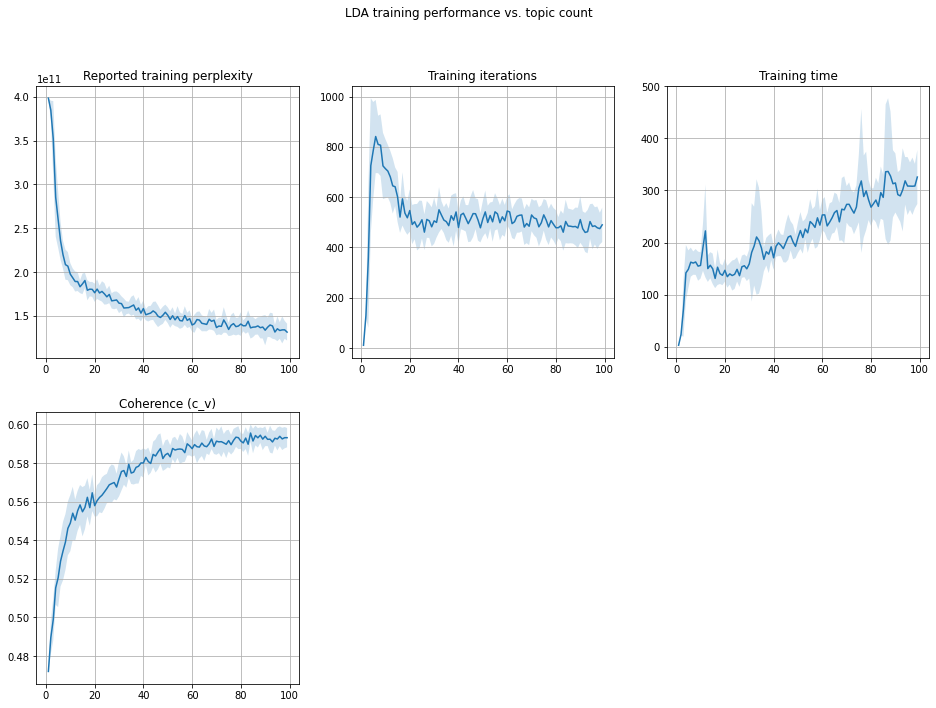

time: 461 ms


In [8]:
import metadata as md
import sqlalchemy as sql
import sqlalchemy.sql.expression as expr

metas = []
for meta in md.session.query(md.Model).filter(
    expr.and_(
        md.Model.dataset == DATASET_NAME,
        md.Model.klass == MODEL_CLASS,
#         md.Model.k.in_(list(TOPIC_COUNTS))
    )).all():
    p = meta.params.copy()
    p.update(CONSTANT_PARAMS)
    if p != meta.params: continue
    metas.append(meta)


fig = plt.figure(figsize=(16,11))
fig.suptitle('LDA training performance vs. topic count')


x,y,s = prep_metric(metas, 'perplexity')

plt.subplot(231)
plt.plot(x,y)
plt.fill_between(x, y-s, y+s, alpha=0.2)
plt.grid()
plt.title('Reported training perplexity')


x,y,s = prep_metric(metas, 'iterations')

plt.subplot(232)
plt.plot(x,y)
plt.fill_between(x, y-s, y+s, alpha=0.2)
plt.grid()
plt.title('Training iterations')


x,y,s = prep_metric(metas, 'duration')

plt.subplot(233)
plt.plot(x,y)
plt.fill_between(x, y-s, y+s, alpha=0.2)
plt.grid()
plt.title('Training time')


x,y,s = prep_metric(metas, 'c_v')

plt.subplot(234)
plt.plot(x,y)
plt.fill_between(x, y-s, y+s, alpha=0.2)
plt.grid()
plt.title('Coherence (c_v)')


# x,y,s = prep_metric(metas, 'c_umass')

# plt.subplot(235)
# plt.plot(x,y)
# plt.fill_between(x, y-s, y+s, alpha=0.2)
# plt.grid()
# plt.title('Coherence (u_mass)')


# x,y,s = prep_metric(metas, 'c_npmi')

# plt.subplot(236)
# plt.plot(x,y)
# plt.fill_between(x, y-s, y+s, alpha=0.2)
# plt.grid()
# plt.title('Coherence (c_npmi)')

plt.show()



In [9]:
m = max(metas, key=lambda m: m.c_v)
print('Best model for c_v: k=%d, c_v=%.3f, uuid=%s' % (m.k, m.c_v, m.uuid))
print(m.params, m.klass, m.dataset, m.iterations)

Best model for c_v: k=92, c_v=0.609, uuid=eb04d483-c4eb-434d-998c-70fd069530ab
{'seed': 8, 'tw': <TermWeight.IDF: 1>} LDAModel 400k-lemma-nophrase-v2 503
time: 2.59 ms


In [10]:
metas_k = filter(lambda m: m.k == 35, metas)
m = max(metas_k, key=lambda m: m.c_v)
print('Best model at K=35: c_v=%.3f, uuid=%s' % (m.c_v, m.uuid))
print(m.params, m.klass, m.dataset, m.iterations)

Best model at K=35: c_v=0.580, uuid=37b49604-0ef1-4171-8b46-e81256ee94ad
{'seed': 10, 'tw': <TermWeight.IDF: 1>} LDAModel 400k-lemma-nophrase-v2 495
time: 13.7 ms


In [12]:
m = max(filter(lambda m: m.k < cal, metas), key=lambda m: m.c_v)
print('Best model for c_v: k=%d, c_v=%.3f, uuid=%s' % (m.k, m.c_v, m.uuid))
print(m.params, m.klass, m.dataset, m.iterations)

Best model for c_v: k=49, c_v=0.602, uuid=94a3f182-1531-4560-96d4-68c7a9180f2e
{'seed': 0, 'tw': <TermWeight.IDF: 1>} LDAModel 400k-lemma-nophrase-v2 547
time: 4.72 ms
